# Predicting Future Crime Rates with Facebook Prophet 

## 78741

In [1]:
# importing necessary libraries and configurations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import logging
import warnings

warnings.filterwarnings("ignore")
logging.getLogger("fbprophet").setLevel(logging.ERROR)
plt.style.use("seaborn")
sb.set_style("whitegrid")
%matplotlib inline

In [2]:
# loading datasets
df = pd.read_csv("df_41.csv")

In [3]:
# data cleaning and indexing

drop = ["zip_code", "latitude", "longitude"]

df.drop(drop, axis=1, inplace=True)
df.occurred_date_time = df.occurred_date_time.astype("datetime64")
df.set_index(["occurred_date_time"], inplace=True)
df.sort_index(inplace=True)

FAMILY DISTURBANCE                20697
BURGLARY OF VEHICLE               19952
THEFT                             15764
CRIMINAL MISCHIEF                 11171
ASSAULT W/INJURY-FAM/DATE VIOL     9736
BURGLARY OF RESIDENCE              8955
PUBLIC INTOXICATION                6403
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5711
HARASSMENT                         5600
Name: highest_offense_description, dtype: int64

FAMILY DISTURBANCE                0.098680
BURGLARY OF VEHICLE               0.095128
THEFT                             0.075160
CRIMINAL MISCHIEF                 0.053262
ASSAULT W/INJURY-FAM/DATE VIOL    0.046420
BURGLARY OF RESIDENCE             0.042696
PUBLIC INTOXICATION               0.030529
CUSTODY ARREST TRAFFIC WARR       0.028660
DWI                               0.027229
HARASSMENT                        0.026700
Name: highest_offense_description, dtype: float64

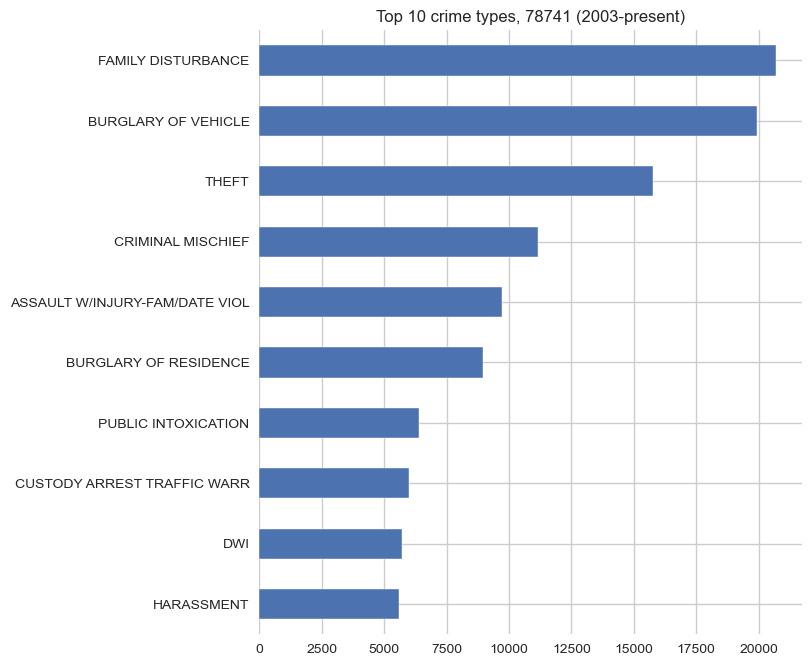

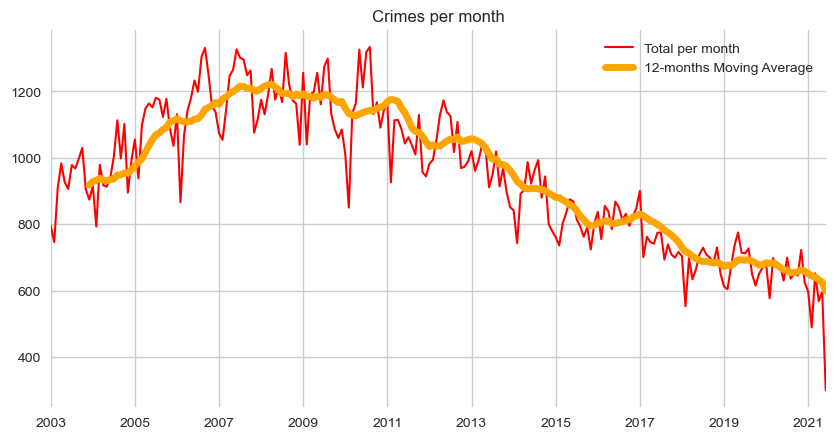

In [4]:
# Create and show dataframe for crime rates by type

display(df.highest_offense_description.value_counts().head(10))
display(df.highest_offense_description.value_counts(normalize=True).head(10))

# Visualizing the top 10 crime types
plt.figure(dpi=100)
df.highest_offense_description.value_counts().head(10).sort_values().plot.barh(
    title="Top 10 crime types, 78741 (2003-present)", figsize=(7, 8)
)
plt.show()

# Using resample 'M' and rolling window 12

plt.figure(figsize=(10, 5), dpi=100)
df.resample("M").size().plot(color="red", linewidth=1.5, label="Total per month")
df.resample("M").size().rolling(window=12).mean().plot(
    color="orange", linewidth=5, label="12-months Moving Average"
)
plt.title("Crimes per month")
plt.xlabel("")
plt.legend()
plt.show()

In [5]:
# Creating separate dataframes for overall & violent crime
df2 = df.query(
    'highest_offense_description == ["FAMILY DISTURBANCE", "THEFT", "BURGLARY OF VEHICLE", "DWI", "CRIMINAL TRESPASS", "PUBLIC INTOXICATION", "BURLARY OF RESIDENCE", "ASSAULT W/INJURY-FAM/DATE VIOL"]'
)

monthly = pd.DataFrame(
    df2[df2["highest_offense_description"] == "FAMILY DISTURBANCE"].resample("M").size()
)
monthly.columns = ["FAMILY DISTURBANCE"]

for i in df2["highest_offense_description"].unique():
    monthly[i] = pd.DataFrame(
        df2[df2["highest_offense_description"] == i].resample("M").size()
    )

monthly["TOTAL"] = monthly.sum(axis=1)

crimeType = monthly.columns

display(monthly.tail())

FAMILY DISTURBANCE  ASSAULT W/INJURY-FAM/DATE VIOL  DWI  \
occurred_date_time                                                            
2021-02-28                          64                              24   11   
2021-03-31                          87                              23   17   
2021-04-30                          63                              23    7   
2021-05-31                          75                              30    9   
2021-06-30                          28                              15    5   

                    BURGLARY OF VEHICLE  PUBLIC INTOXICATION  THEFT  \
occurred_date_time                                                    
2021-02-28                           19                    8     25   
2021-03-31                           34                    3     51   
2021-04-30                           38                    8     32   
2021-05-31                           34                    3     35   
2021-06-30                           13                    1     15   

                    CRIMINAL TRESPASS  TOTAL  
occurred_date_time                            
2021-02-28                          9    160  
2021-03-31                         17    232  
2021-04-30                         13    184  
2021-05-31                         19    205  
2021-06-30                         10     87

-----------------------------------------------------------------
Calculating and plotting time series with moving average included
-----------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

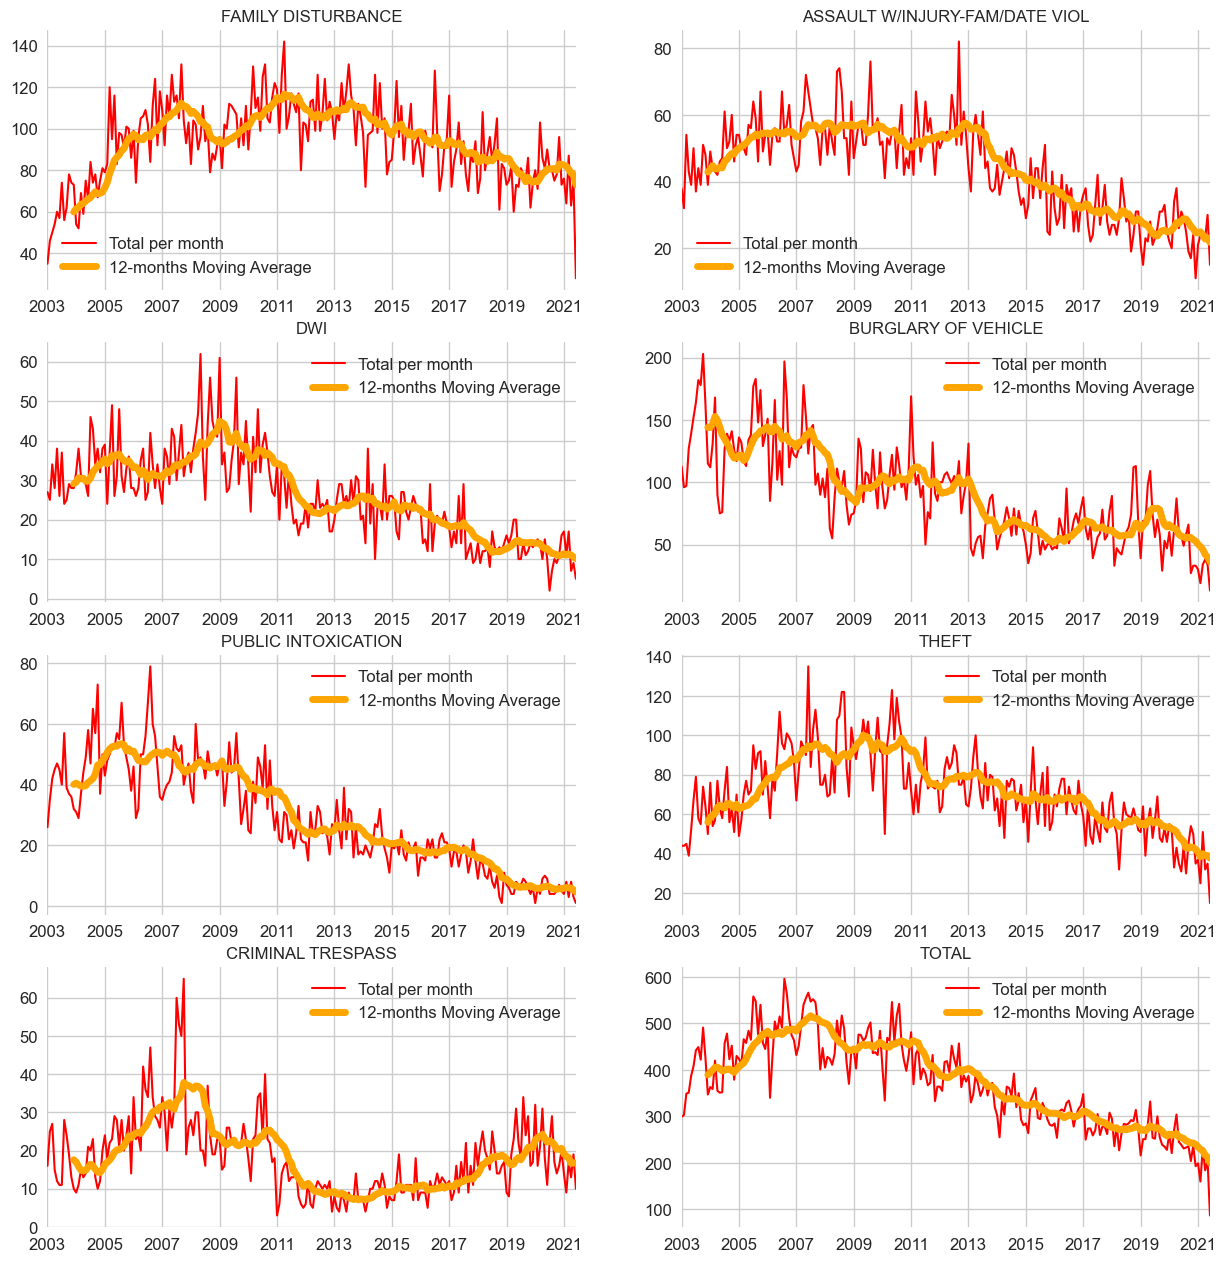

-----------------------------------------------
 Calculating and visualizing the 1st difference
-----------------------------------------------


<Figure size 432x288 with 0 Axes>

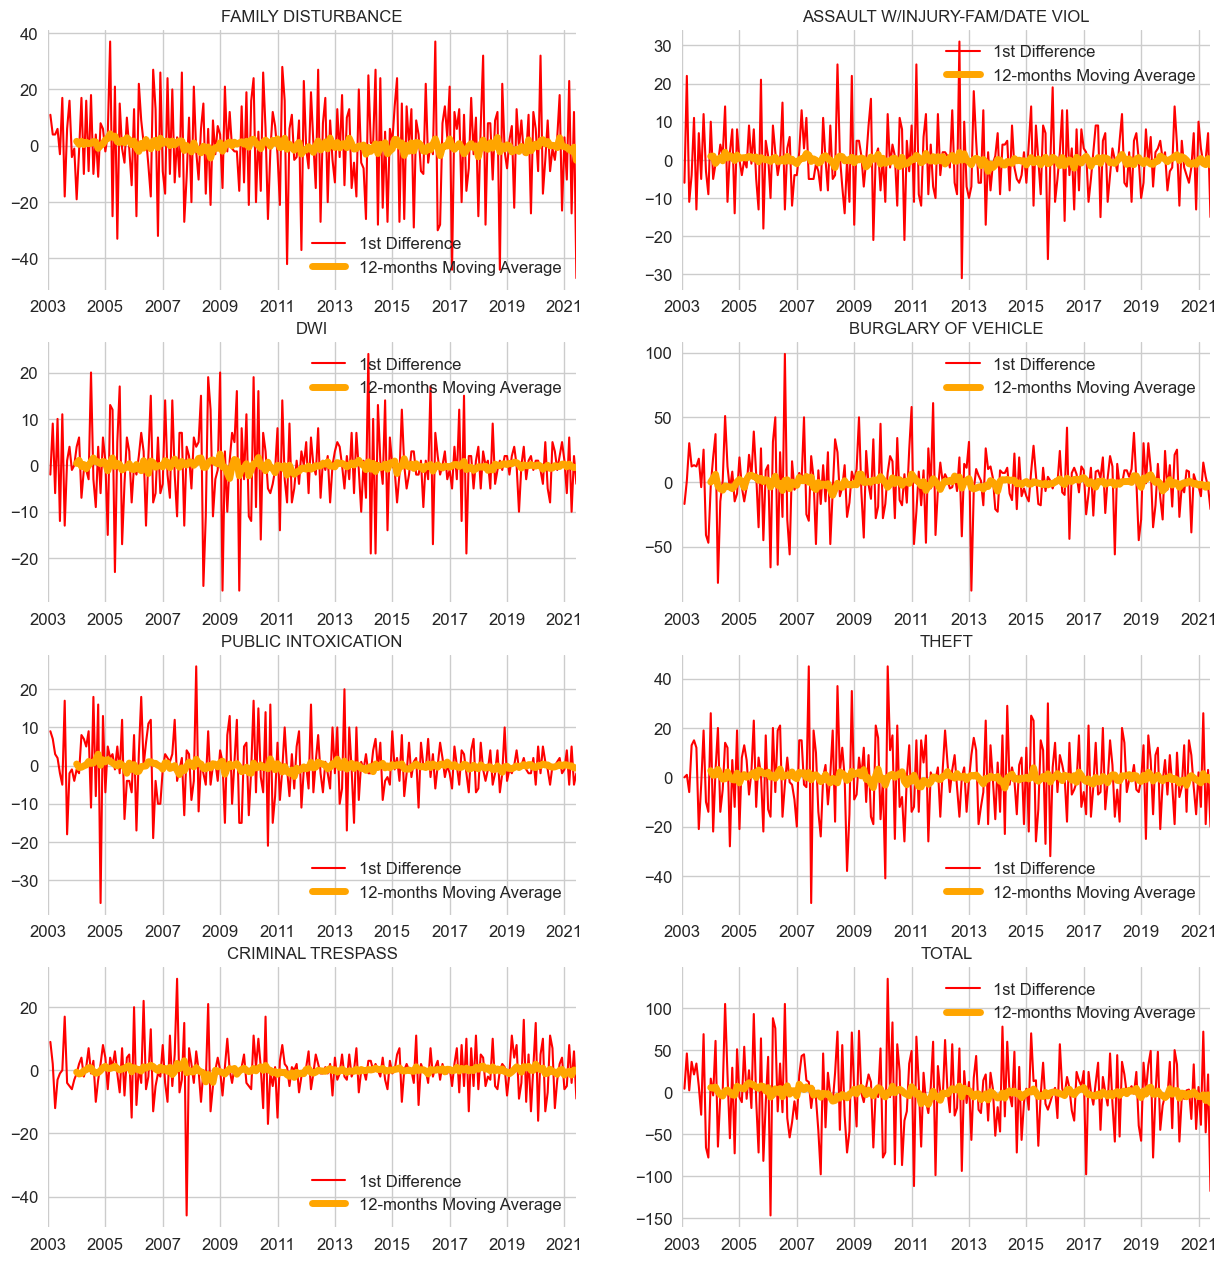

In [6]:
print("-----------------------------------------------------------------")
print("Calculating and plotting time series with moving average included")
print("-----------------------------------------------------------------")
plt.figure(1)
plt.figure(figsize=(15, 20), dpi=100)

i = 521
for eachCrime in crimeType:
    plt.subplot(i)
    monthly[eachCrime].plot(color="red", linewidth=1.5, label="Total per month")
    monthly[eachCrime].rolling(window=12).mean().plot(
        color="orange", linewidth=5, label="12-months Moving Average"
    )
    plt.title(eachCrime, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
    i = i + 1
plt.show()

print("-----------------------------------------------")
print(" Calculating and visualizing the 1st difference")
print("-----------------------------------------------")
# Initiate the figure and define size
plt.figure(1)
plt.figure(figsize=(15, 20), dpi=100)

# Using a for loop to plot each type of crime with a moving average
i = 521
for eachCrime in crimeType:
    plt.subplot(i)
    monthly[eachCrime].diff().plot(color="red", linewidth=1.5, label="1st Difference")
    monthly[eachCrime].rolling(window=12).mean().diff().plot(
        color="orange", linewidth=5, label="12-months Moving Average"
    )
    plt.title(eachCrime, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
    i = i + 1

In [7]:
# Create a data frame with the 1st difference

montlhy_1stDiff = monthly.diff().dropna()

# Create a data frame with the results of the ADF test for each type

adfullerResults = pd.DataFrame(
    columns=crimeType,
    index=["ADF", "Critical Value 1%", "Critical Value 5%", "p-value"],
)
for eachType in crimeType:
    adf = adfuller(montlhy_1stDiff[eachType])
    adfullerResults[eachType] = (
        "{:.4f}".format(adf[0]),
        "{:.4f}".format(adf[4]["1%"]),
        "{:.4f}".format(adf[4]["5%"]),
        "{:.4f}".format(adf[1]),
    )
adfullerResults

FAMILY DISTURBANCE ASSAULT W/INJURY-FAM/DATE VIOL      DWI  \
ADF                          -7.7593                        -8.2968  -9.0764   
Critical Value 1%            -3.4614                        -3.4619  -3.4614   
Critical Value 5%            -2.8752                        -2.8754  -2.8752   
p-value                       0.0000                         0.0000   0.0000   

                  BURGLARY OF VEHICLE PUBLIC INTOXICATION    THEFT  \
ADF                           -8.6557             -5.1509  -8.0510   
Critical Value 1%             -3.4616             -3.4623  -3.4619   
Critical Value 5%             -2.8753             -2.8756  -2.8754   
p-value                        0.0000              0.0000   0.0000   

                  CRIMINAL TRESPASS    TOTAL  
ADF                         -7.5465  -5.6812  
Critical Value 1%           -3.4617  -3.4620  
Critical Value 5%           -2.8753  -2.8755  
p-value                      0.0000   0.0000

'FAMILY DISTURBANCE'

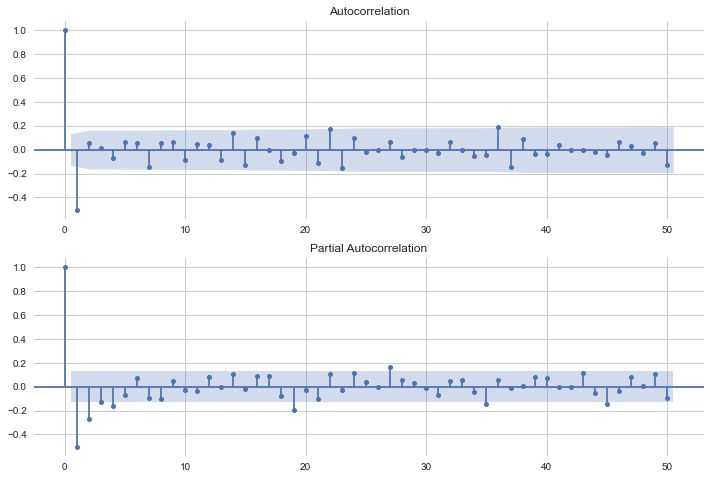

In [8]:
display(montlhy_1stDiff[crimeType[0]].name)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(montlhy_1stDiff[crimeType[0]], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(montlhy_1stDiff[crimeType[0]], lags=50, ax=ax2)

In [9]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print("Examples of parameter combinations for Seasonal ARIMA...")
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[1]))
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[2]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[3]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [10]:
# Creating a function to use a pipeline
def myArima(crimeTypeSeries):
    print("Training for:", crimeTypeSeries.name)
    lowestAIC = 999999999
    bestOrder = 0
    bestSeasonal_order = 0
    i = 0
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    crimeTypeSeries, order=param, seasonal_order=param_seasonal
                )
                results = mod.fit()
                newAIC = results.aic
                if newAIC < lowestAIC:
                    lowestAIC = newAIC
                    bestOrder = param
                    bestSeasonal_order = param_seasonal
                i = i + 1
                print("\r", "Calculating: {:.0f}%".format(i / 64 * 100), end="")
            except:
                i = i + 1
                print("\r", "Calculating: {:.0f}%".format(i / 64 * 100), end="")
                continue
    print("\nBest parameters: SARIMA{}x{}12".format(param, param_seasonal))
    mod = sm.tsa.statespace.SARIMAX(
        crimeTypeSeries, order=bestOrder, seasonal_order=bestSeasonal_order
    )
    results = mod.fit()
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    pred = results.get_prediction(start=168, end=230, dynamic=False)
    pred_ci = pred.conf_int()
    pred_ci.head()
    plt.figure(figsize=(15, 6))
    ax = crimeTypeSeries.plot(label="observed")
    plt.title("Actual and Forecast", fontsize=12)
    pred.predicted_mean.plot(
        ax=ax, label="One-step ahead forecast", color="red", alpha=0.7, lw=4
    )
    ax.fill_between(
        pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="r", alpha=0.3
    )
    ax.set_xlabel("Years")
    ax.set_ylabel("Number of crime")
    plt.legend()
    plt.show()
    return results

Training for: FAMILY DISTURBANCE
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


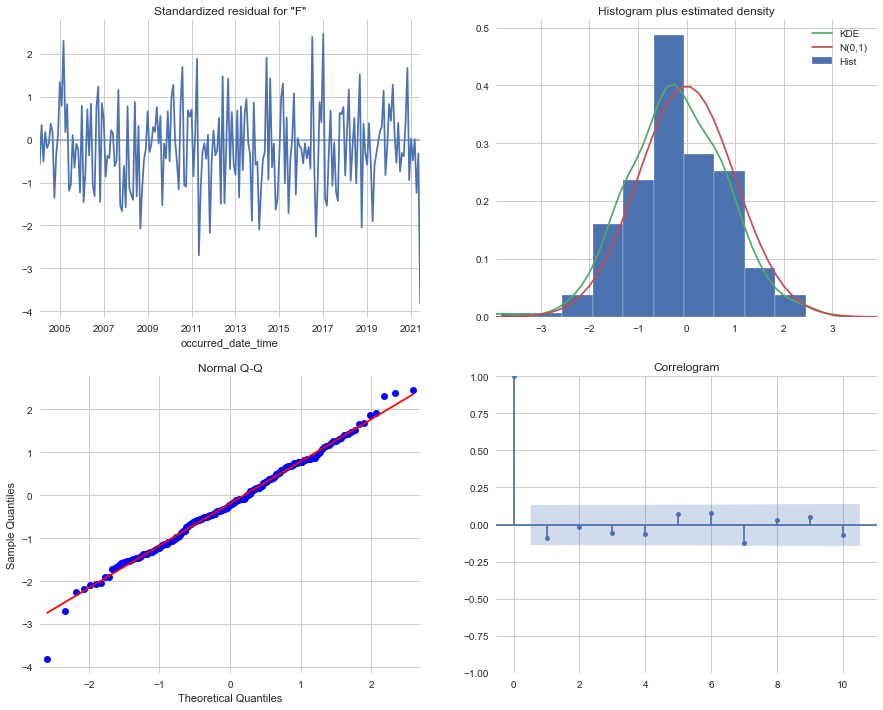

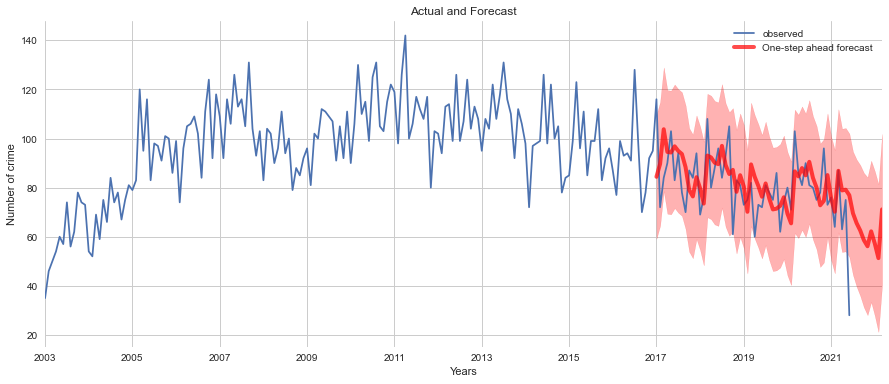

Training for: ASSAULT W/INJURY-FAM/DATE VIOL
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


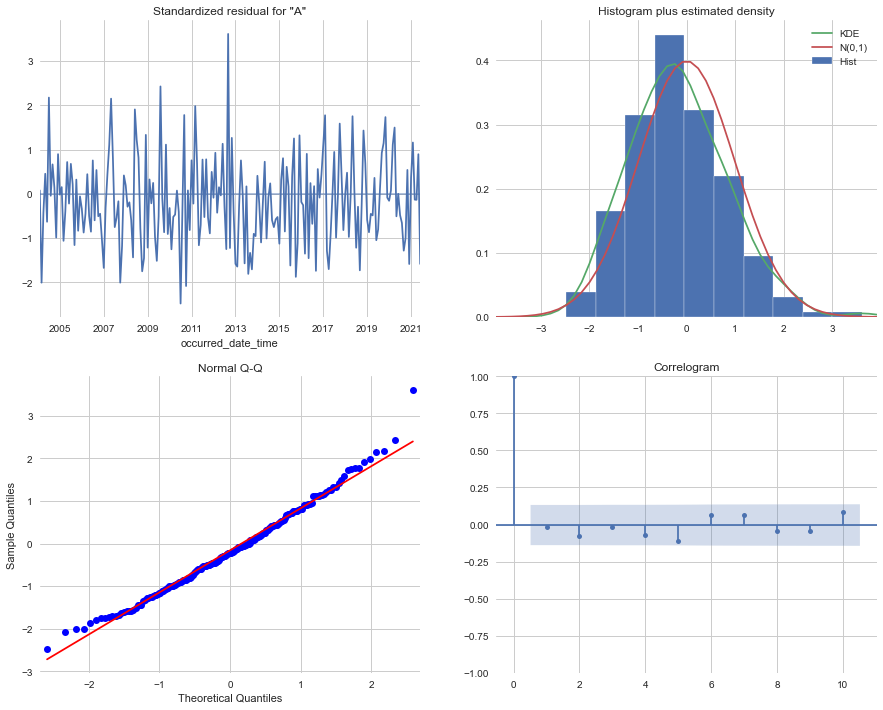

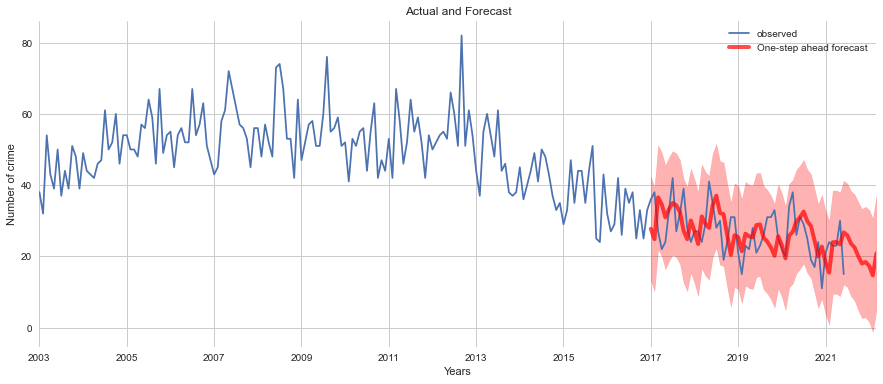

Training for: DWI
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


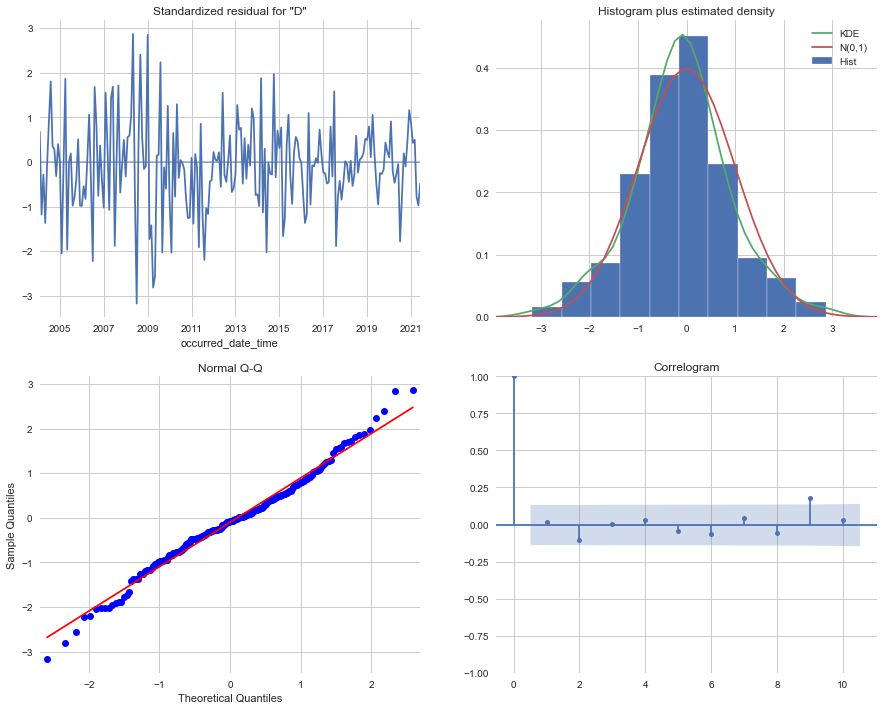

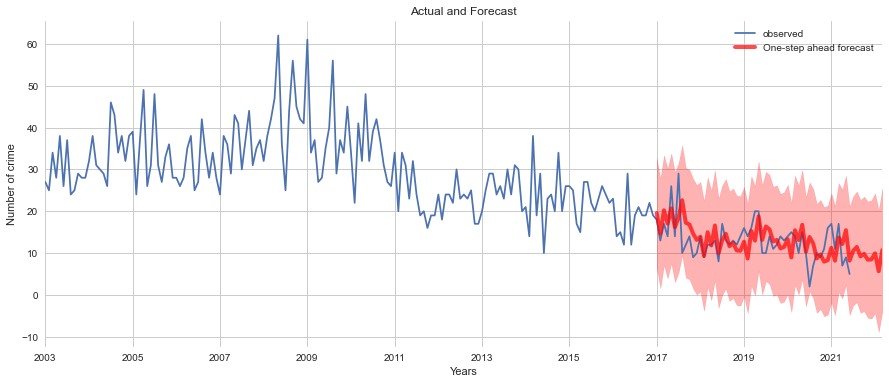

Training for: BURGLARY OF VEHICLE
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


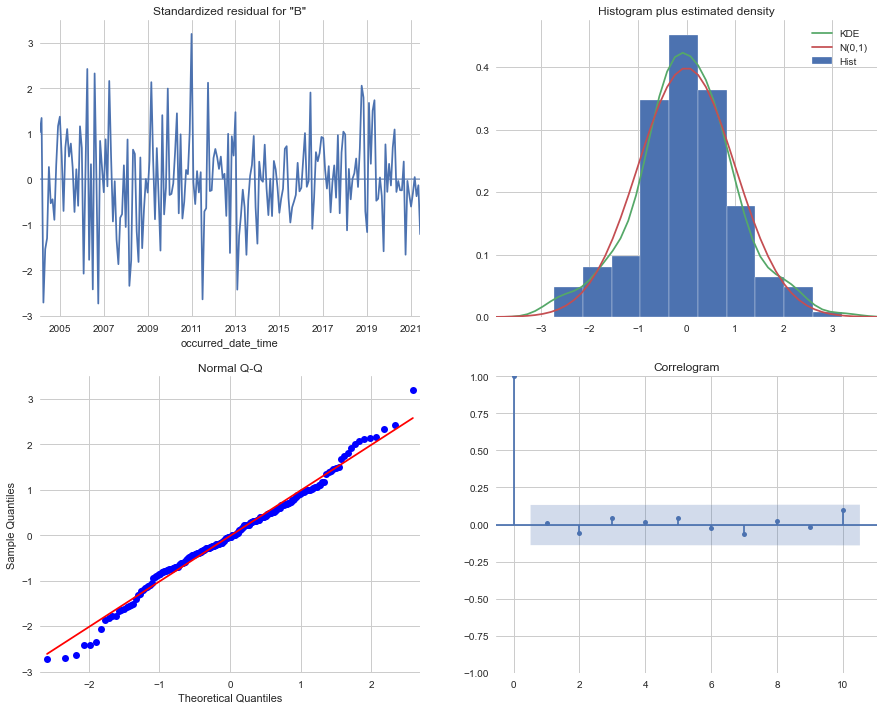

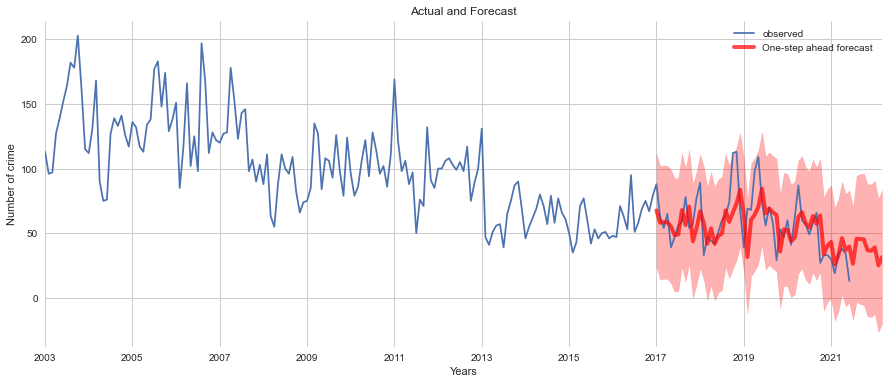

Training for: PUBLIC INTOXICATION
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


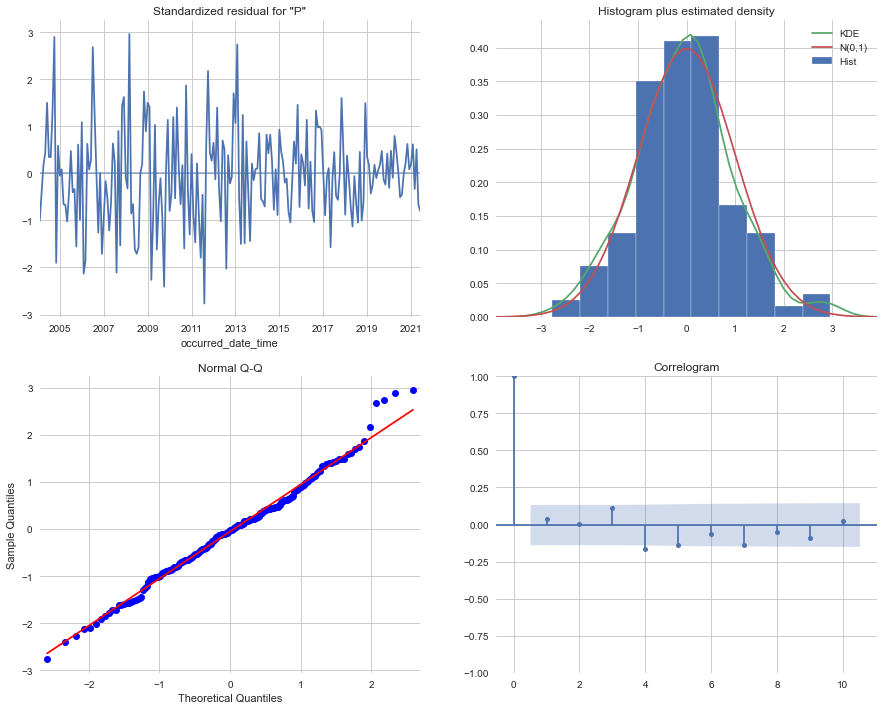

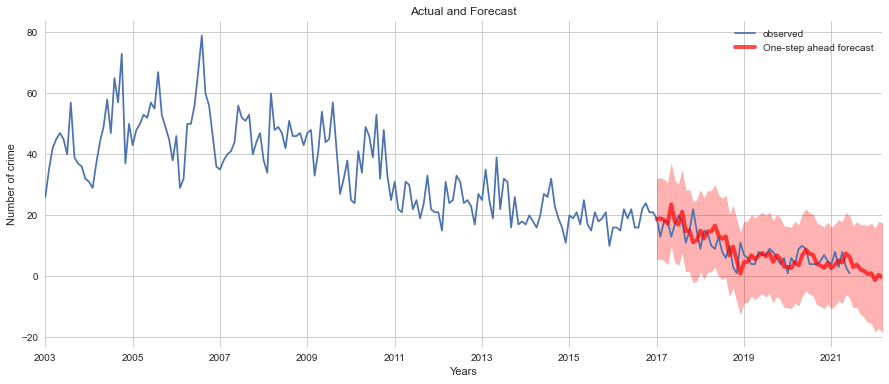

Training for: THEFT
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


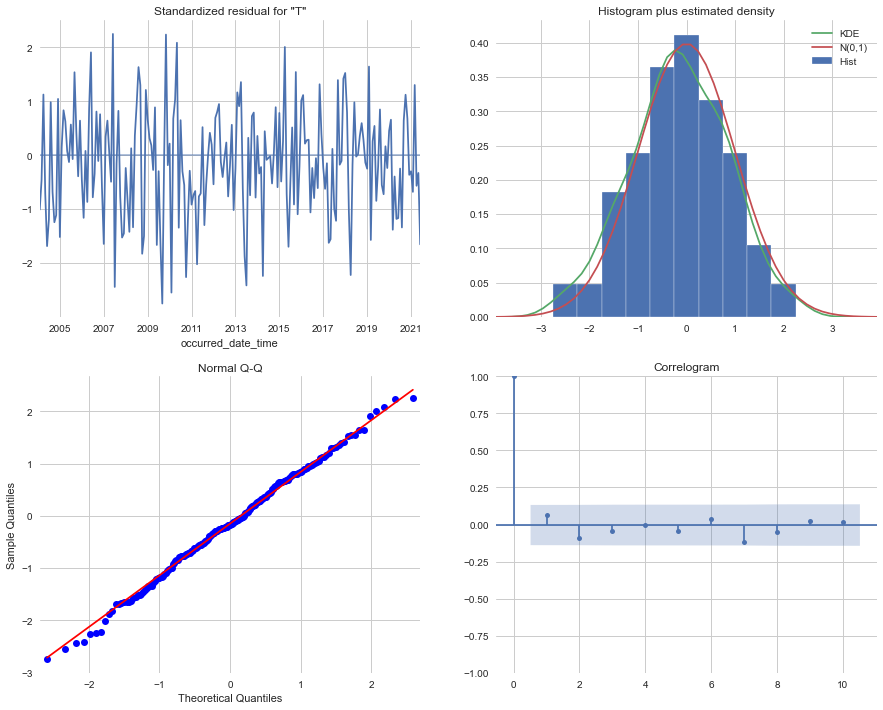

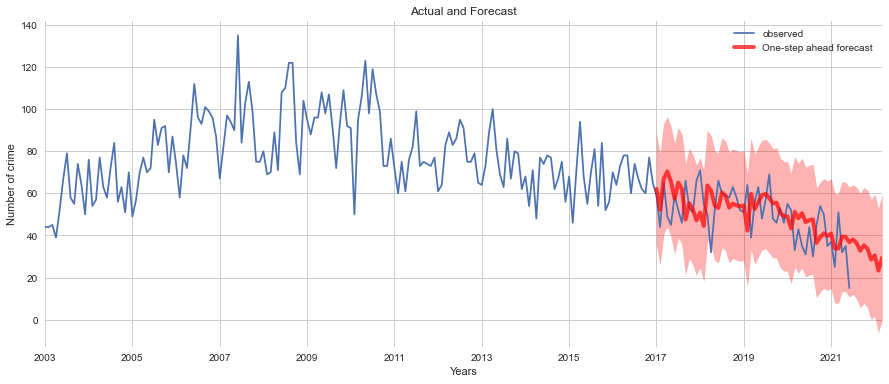

Training for: CRIMINAL TRESPASS
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


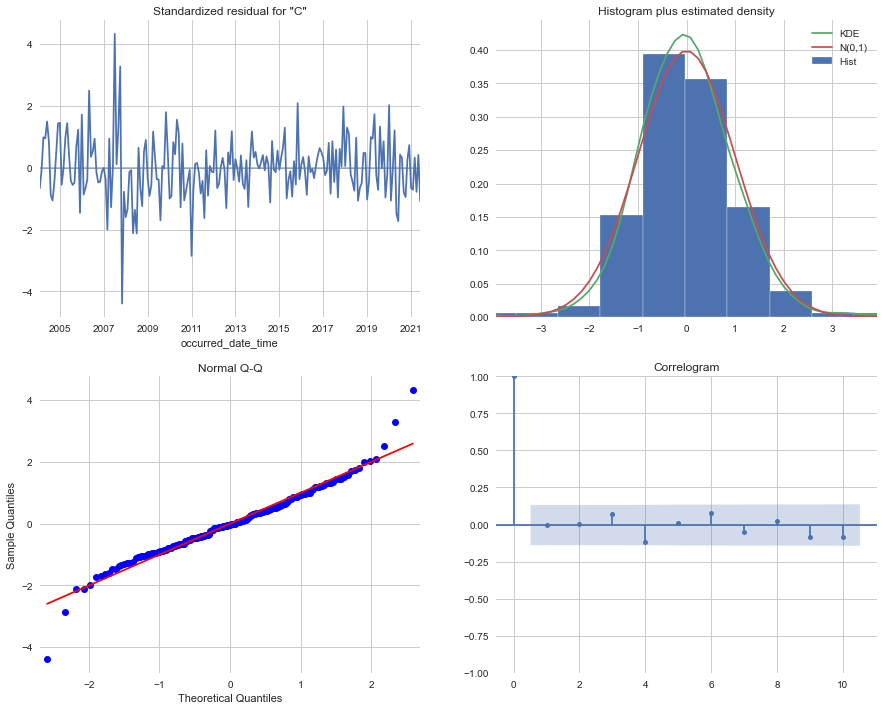

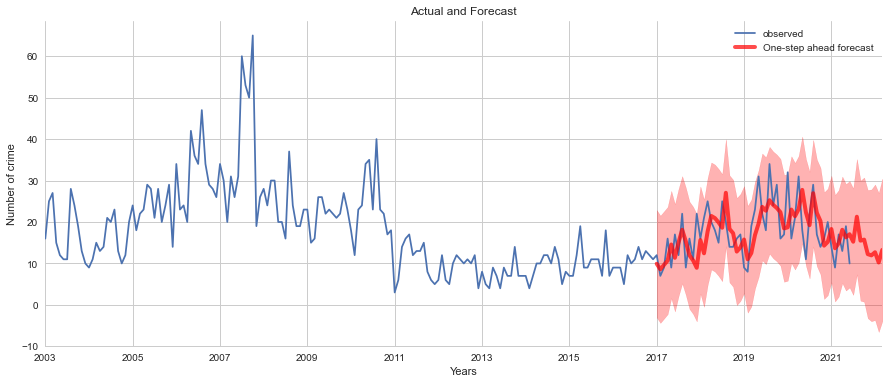

Training for: TOTAL
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


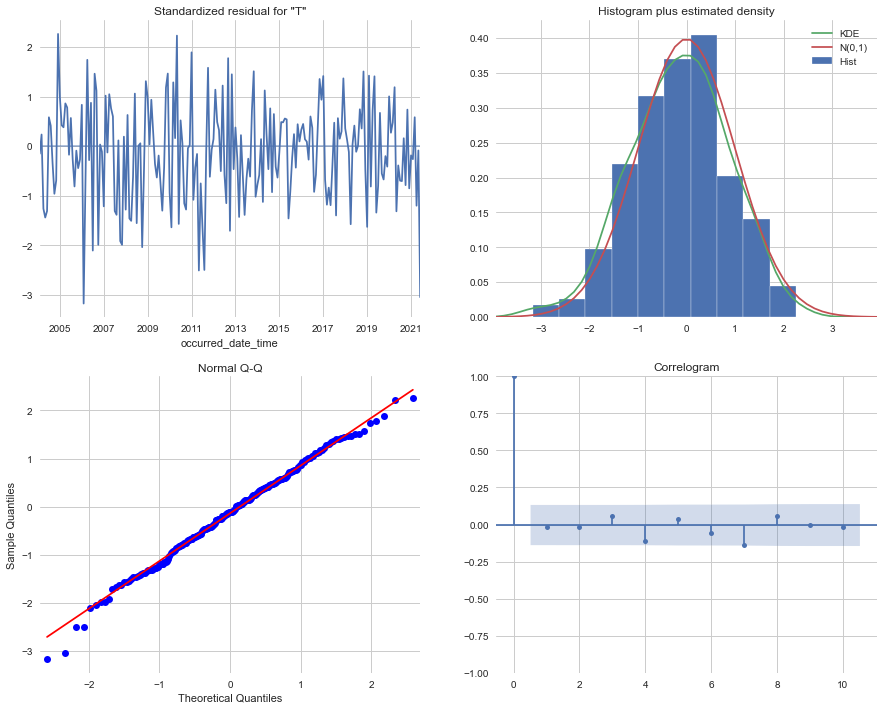

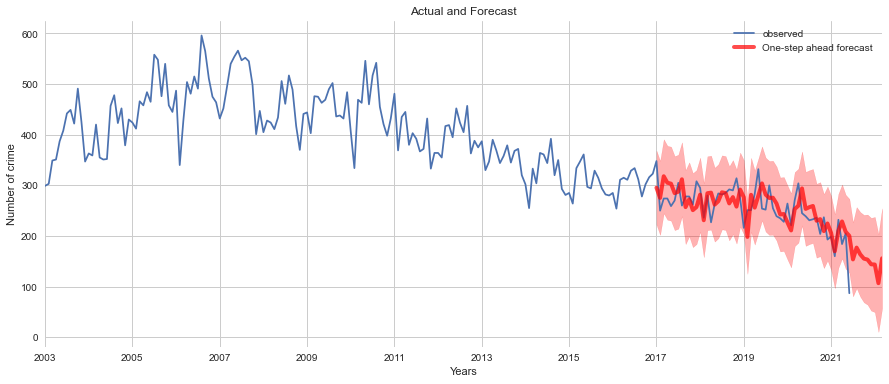

In [11]:
results = []
for i in crimeType:
    results.append(myArima(monthly[i]))

In [12]:
predictions = []
for i in range(0, len(results)):
    predictions.append(
        results[i].get_prediction(start=204, end=230, dynamic=False).predicted_mean
    )

In [13]:
# Calculating MAPE error
predictions = pd.DataFrame(predictions)
predictions = predictions.transpose()
predictions.columns = monthly.columns
errors = (monthly - predictions) / monthly
errors.dropna(how="all", inplace=True)
n = len(errors)

MAPE = round((errors.abs().sum() / n) * 100, 2)
print(
    "The Mean Absolute Percentage Error for each type for the year 01/2020 to 12/2021"
)
display(MAPE)

The Mean Absolute Percentage Error for each type for the year 01/2020 to 12/2021


FAMILY DISTURBANCE                18.74
ASSAULT W/INJURY-FAM/DATE VIOL    26.77
DWI                               64.13
BURGLARY OF VEHICLE               33.17
PUBLIC INTOXICATION               84.80
THEFT                             33.02
CRIMINAL TRESPASS                 34.39
TOTAL                             17.12
dtype: float64

In [14]:
# Formulating the confidence interval
predictions_ci = []
for i in range(0, len(results)):
    predictions_ci.append(
        results[i].get_prediction(start=204, end=230, dynamic=False).conf_int()
    )

# display(predictions_ci)

# Building a forecast table
def forecastMonth(year_month):
    for i in range(0, 9):
        pred_df = round(predictions.iloc[:, i : i + 1][year_month], 0)
        ci_df = round(predictions_ci[i][year_month], 0)
        ci_df.columns = ["Lower CI", "Upper CI"]
        frames = (pred_df, ci_df)
        display(pd.concat(frames, axis=1))


forecastMonth("2021-06")

FAMILY DISTURBANCE  Lower CI  Upper CI
2021-06-30                77.0      52.0     102.0

ASSAULT W/INJURY-FAM/DATE VIOL  Lower CI  Upper CI
2021-06-30                            27.0      12.0      41.0

DWI  Lower CI  Upper CI
2021-06-30  8.0      -5.0      21.0

BURGLARY OF VEHICLE  Lower CI  Upper CI
2021-06-30                 40.0      -4.0      83.0

PUBLIC INTOXICATION  Lower CI  Upper CI
2021-06-30                  6.0      -7.0      20.0

THEFT  Lower CI  Upper CI
2021-06-30   37.0      11.0      63.0

CRIMINAL TRESPASS  Lower CI  Upper CI
2021-06-30               17.0       4.0      30.0

TOTAL  Lower CI  Upper CI
2021-06-30  200.0     127.0     273.0

IndexError: list index out of range

## Predicting crime rates with Facebook Prophet 

### Modeling the data as-is

In [ ]:
# Prepping to forecast
df_fbprophet = df.copy()
df_m = df_fbprophet.resample("D").size().reset_index()
df_m.columns = ["date", "daily_crime_count"]
df_m_final = df_m.rename(columns={"date": "ds", "daily_crime_count": "y"})
df_m_final["y"] = np.log(df_m_final["y"])
# df_m_final["y"] = pd.to_numeric(df_m_final["y"])
y = df_m_final["y"].to_frame()
y.index = df_m_final["ds"]
n = np.int(y.count())

# Fitting and configuring the model
m = Prophet(interval_width=0.95)
m.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m.add_seasonality(name="weekly", period=52, fourier_order=10)
m.add_seasonality(name="daily", period=366, fourier_order=10)
m.fit(df_m_final)

future = m.make_future_dataframe(periods=366, freq="D")

forecast = m.predict(future)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

fig2 = m.plot_components(forecast)

fig2_1 = plot_plotly(m, forecast)
fig2_1

In [ ]:
# The forecast is 'log transformed', so we need to 'inverse' it back by using the exp
forecast_df_exp = np.exp(forecast[["yhat", "yhat_lower", "yhat_upper"]])
forecast_df_exp.index = forecast["ds"]

# Calculating MAPE error
error = forecast_df_exp["yhat"] - y["y"]
MAPE_df = (error / y["y"]).abs().sum() / n * 100
round(MAPE_df, 2)

### Mitigating outlier effects on moodel accuracy 

In [ ]:
# Make another copy of the data frame as m2
df_prophet2 = df_m_final.copy()

# Define the Upper Control Limit and Lower Control Limit as 3 standard deviations from the mean
ucl = df_prophet2.mean() + df_prophet2.std() * 3
lcl = df_prophet2.mean() - df_prophet2.std() * 3

# display the number of outliers found
print(
    "Above 3 standard deviations: ",
    df_prophet2[df_prophet2["y"] > ucl["y"]]["y"].count(),
    "entries",
)
print(
    "Below 3 standard deviations: ",
    df_prophet2[df_prophet2["y"] < lcl["y"]]["y"].count(),
    "entries",
)

In [ ]:
# Remove them by setting their value to None. Prophet says it can handle null values.
df_prophet2.loc[df_prophet2["y"] > ucl["y"], "y"] = None
df_prophet2.loc[df_prophet2["y"] < lcl["y"], "y"] = None

# Log transformation
df_prophet2["y"] = np.log(df_prophet2["y"])
# df_prophet2["y"] = pd.to_numeric(df_prophet2["y"])

# Run Prophet using model 2
m2 = Prophet(interval_width=0.95)
m2.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m2.add_seasonality(name="weekly", period=52, fourier_order=10)
m2.add_seasonality(name="daily", period=366, fourier_order=10)
m2.fit(df_prophet2)

future = m2.make_future_dataframe(periods=366)

forecast_m2 = m2.predict(future)

fig_m2 = m2.plot(forecast_m2)
a = add_changepoints_to_plot(fig_m2.gca(), m2, forecast_m2)

fig2m2 = m2.plot_components(forecast_m2)

fig2_1m2 = plot_plotly(m2, forecast_m2)
fig2_1m2

In [ ]:
# Re-inversing the forecast
forecast_m2_exp = np.exp(forecast_m2[["yhat", "yhat_lower", "yhat_upper"]])
forecast_m2_exp.index = forecast_m2["ds"]

# RecalculatinG MAPE error
error = forecast_m2_exp["yhat"] - y["y"]
MAPE_m2 = (error / y["y"]).abs().sum() / n * 100
round(MAPE_m2, 2)

  horizon       mse      rmse       mae      mape     mdape  coverage
0 36 days  0.005185  0.072007  0.058039  0.051444  0.041233  0.902778
1 37 days  0.005503  0.074179  0.059585  0.053033  0.044116  0.895833
2 38 days  0.005552  0.074509  0.060293  0.053695  0.048047  0.895833
3 39 days  0.005558  0.074551  0.060272  0.053699  0.049692  0.895833
4 40 days  0.005452  0.073836  0.059452  0.052951  0.046591  0.895833


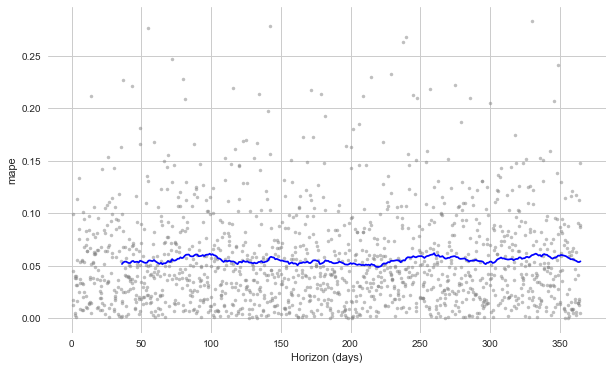

In [20]:
# Doing a diagnostic and performance metrics check visualizing the results

b = cross_validation(m2, initial="5110 days", period="365 days", horizon="365 days")

p = performance_metrics(b)
print(p.head())

fig4 = plot_cross_validation_metric(b, metric="mape")